In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('indian_multi_insurance_fraud_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())
print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
print("\nInsurance Types Distribution:")
print(df['insurance_type'].value_counts())

ModuleNotFoundError: No module named 'pandas'

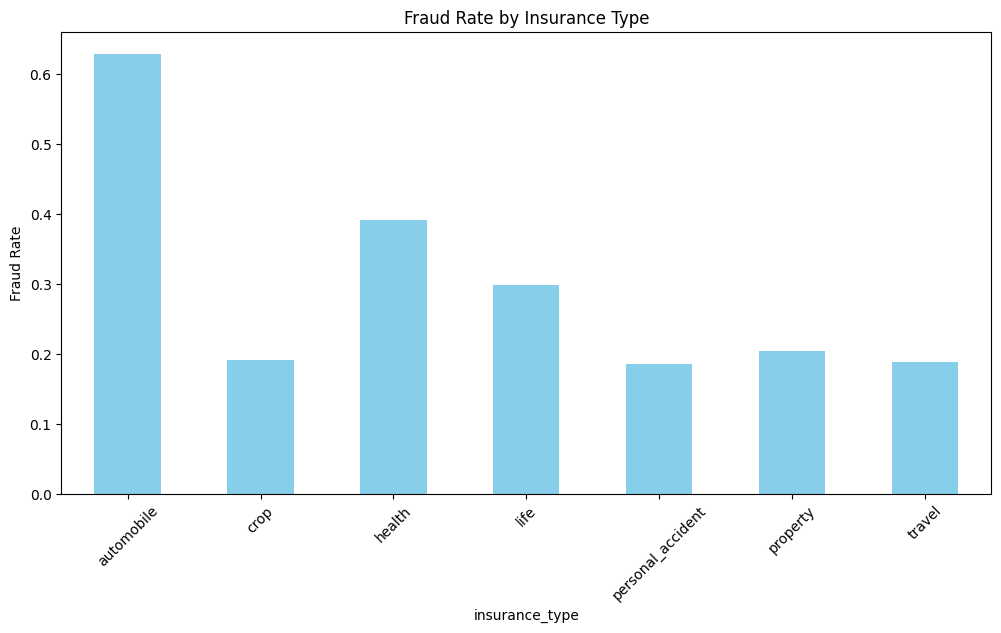

<Figure size 1500x800 with 0 Axes>

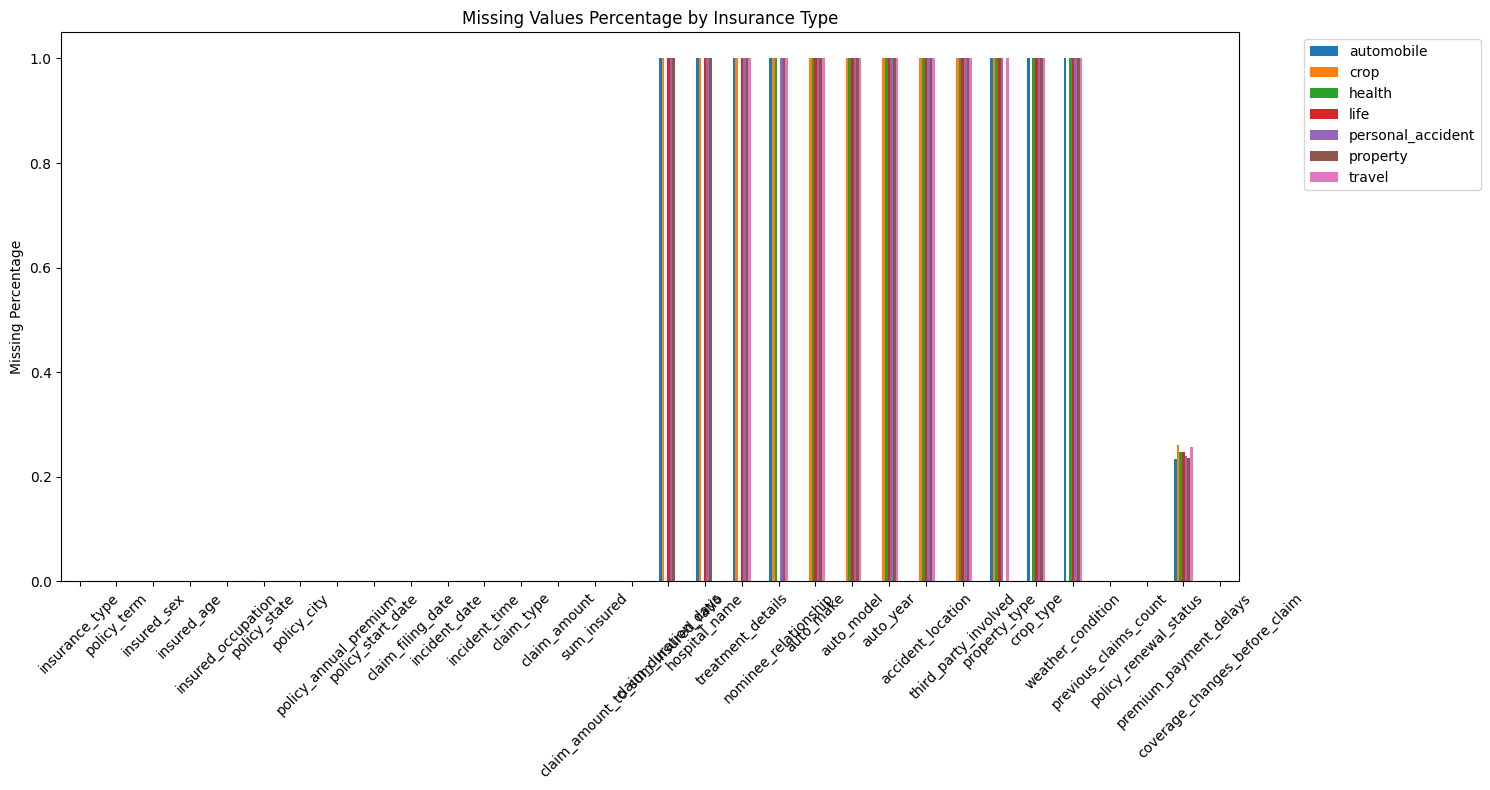

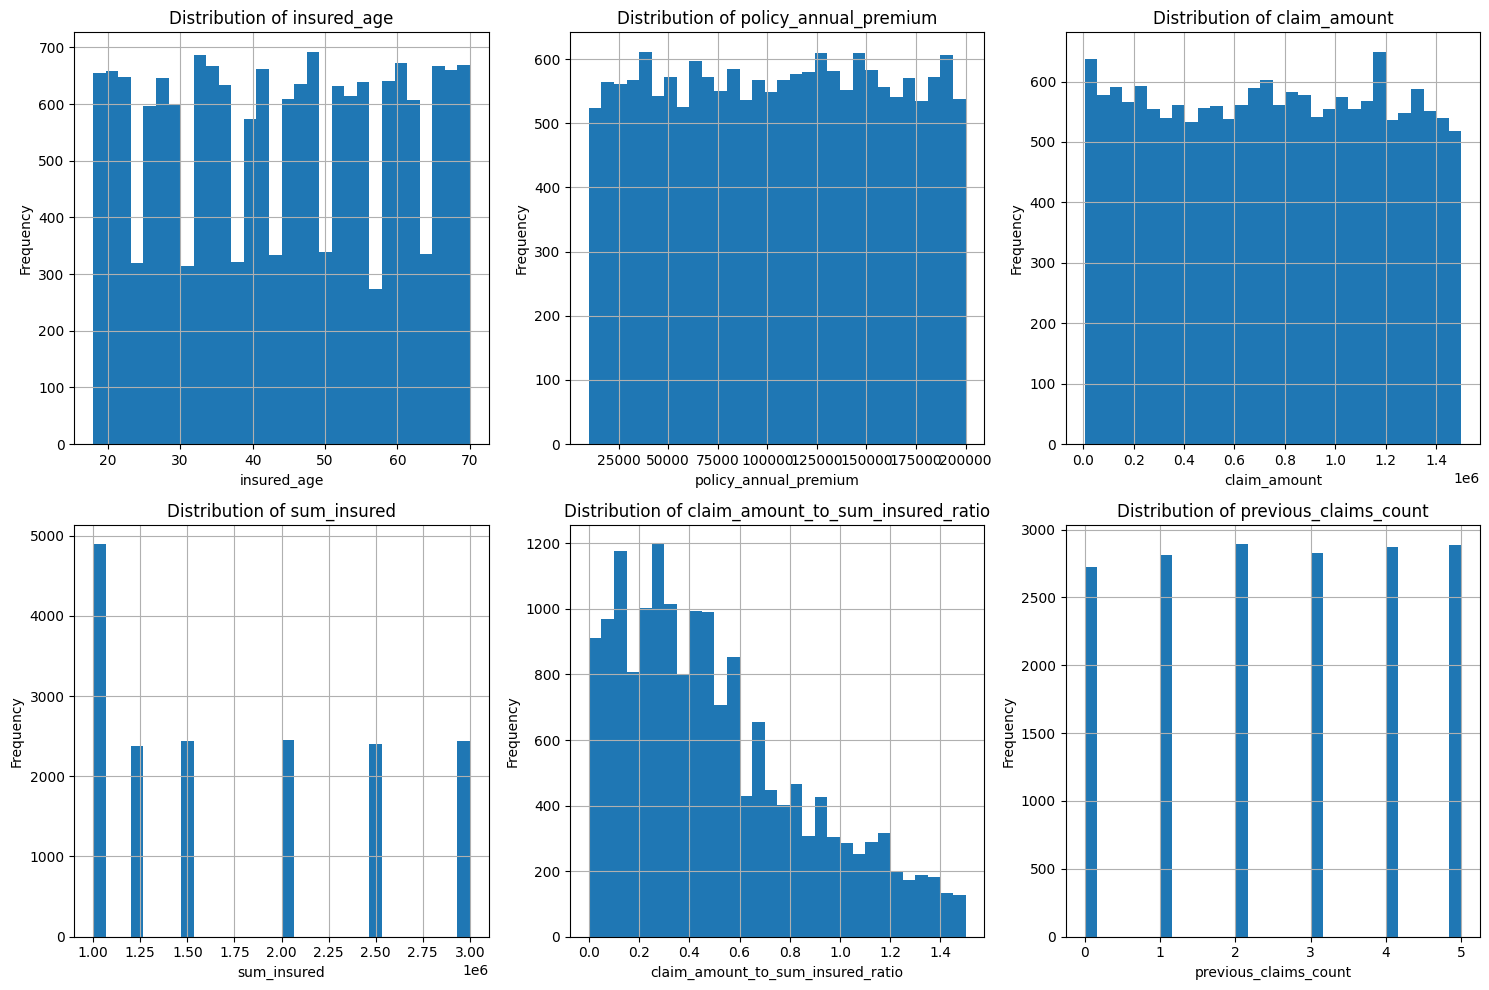

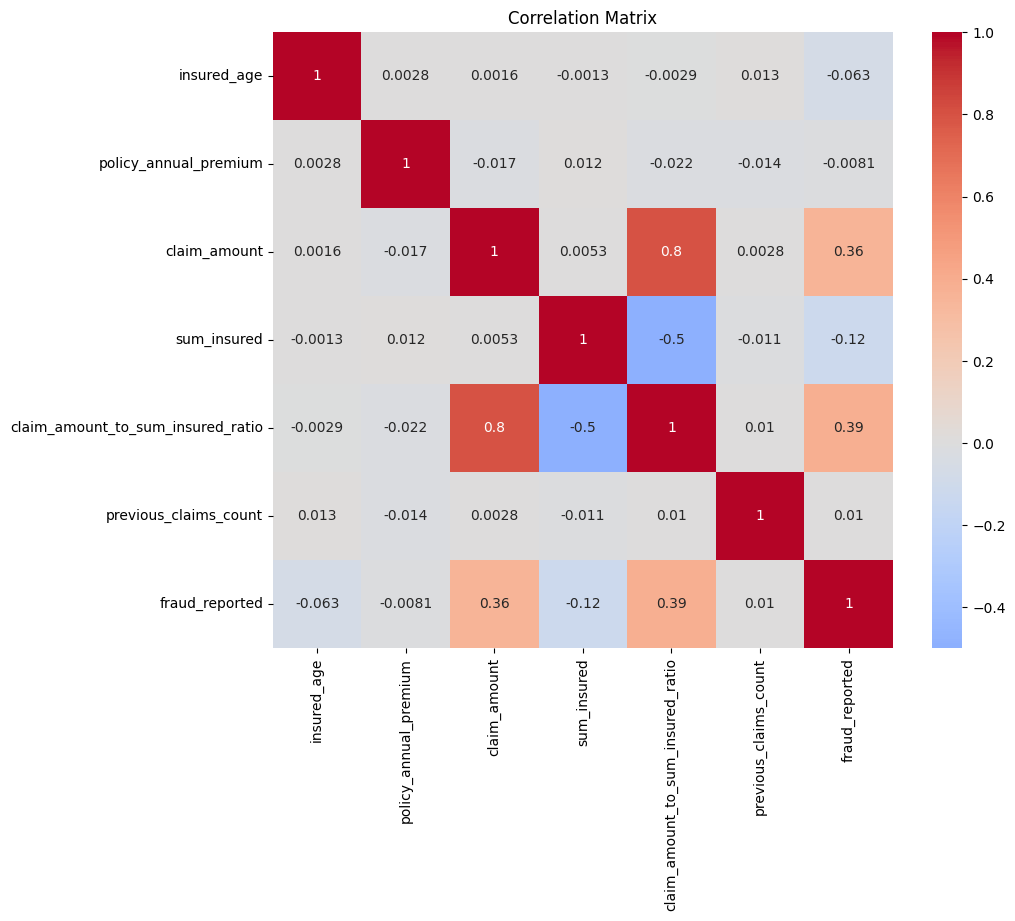

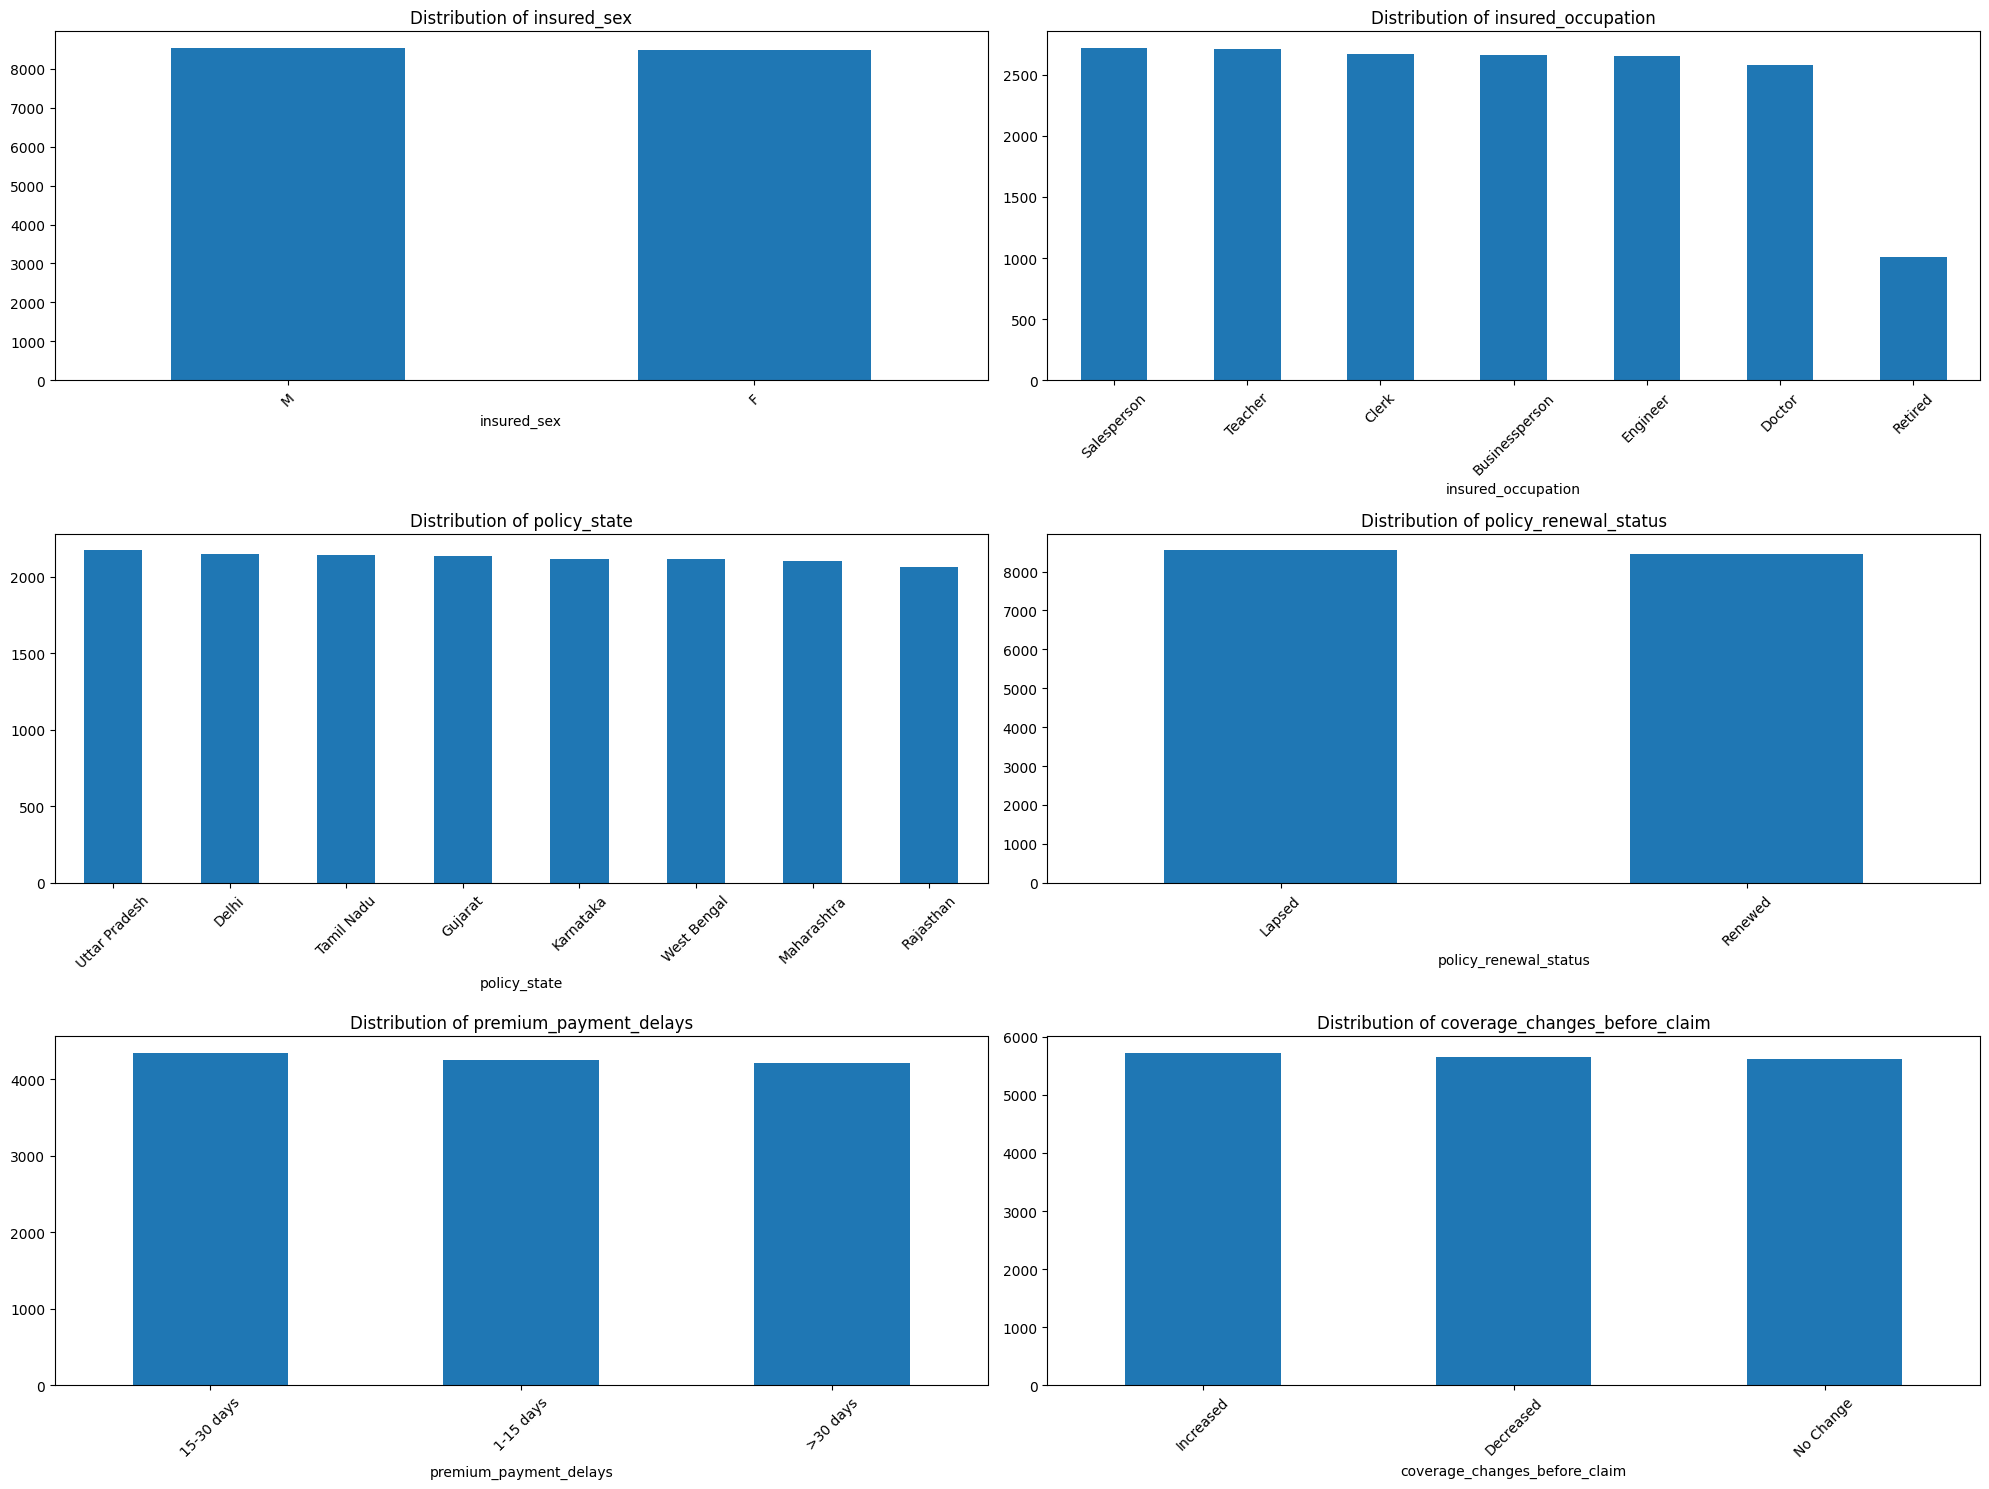

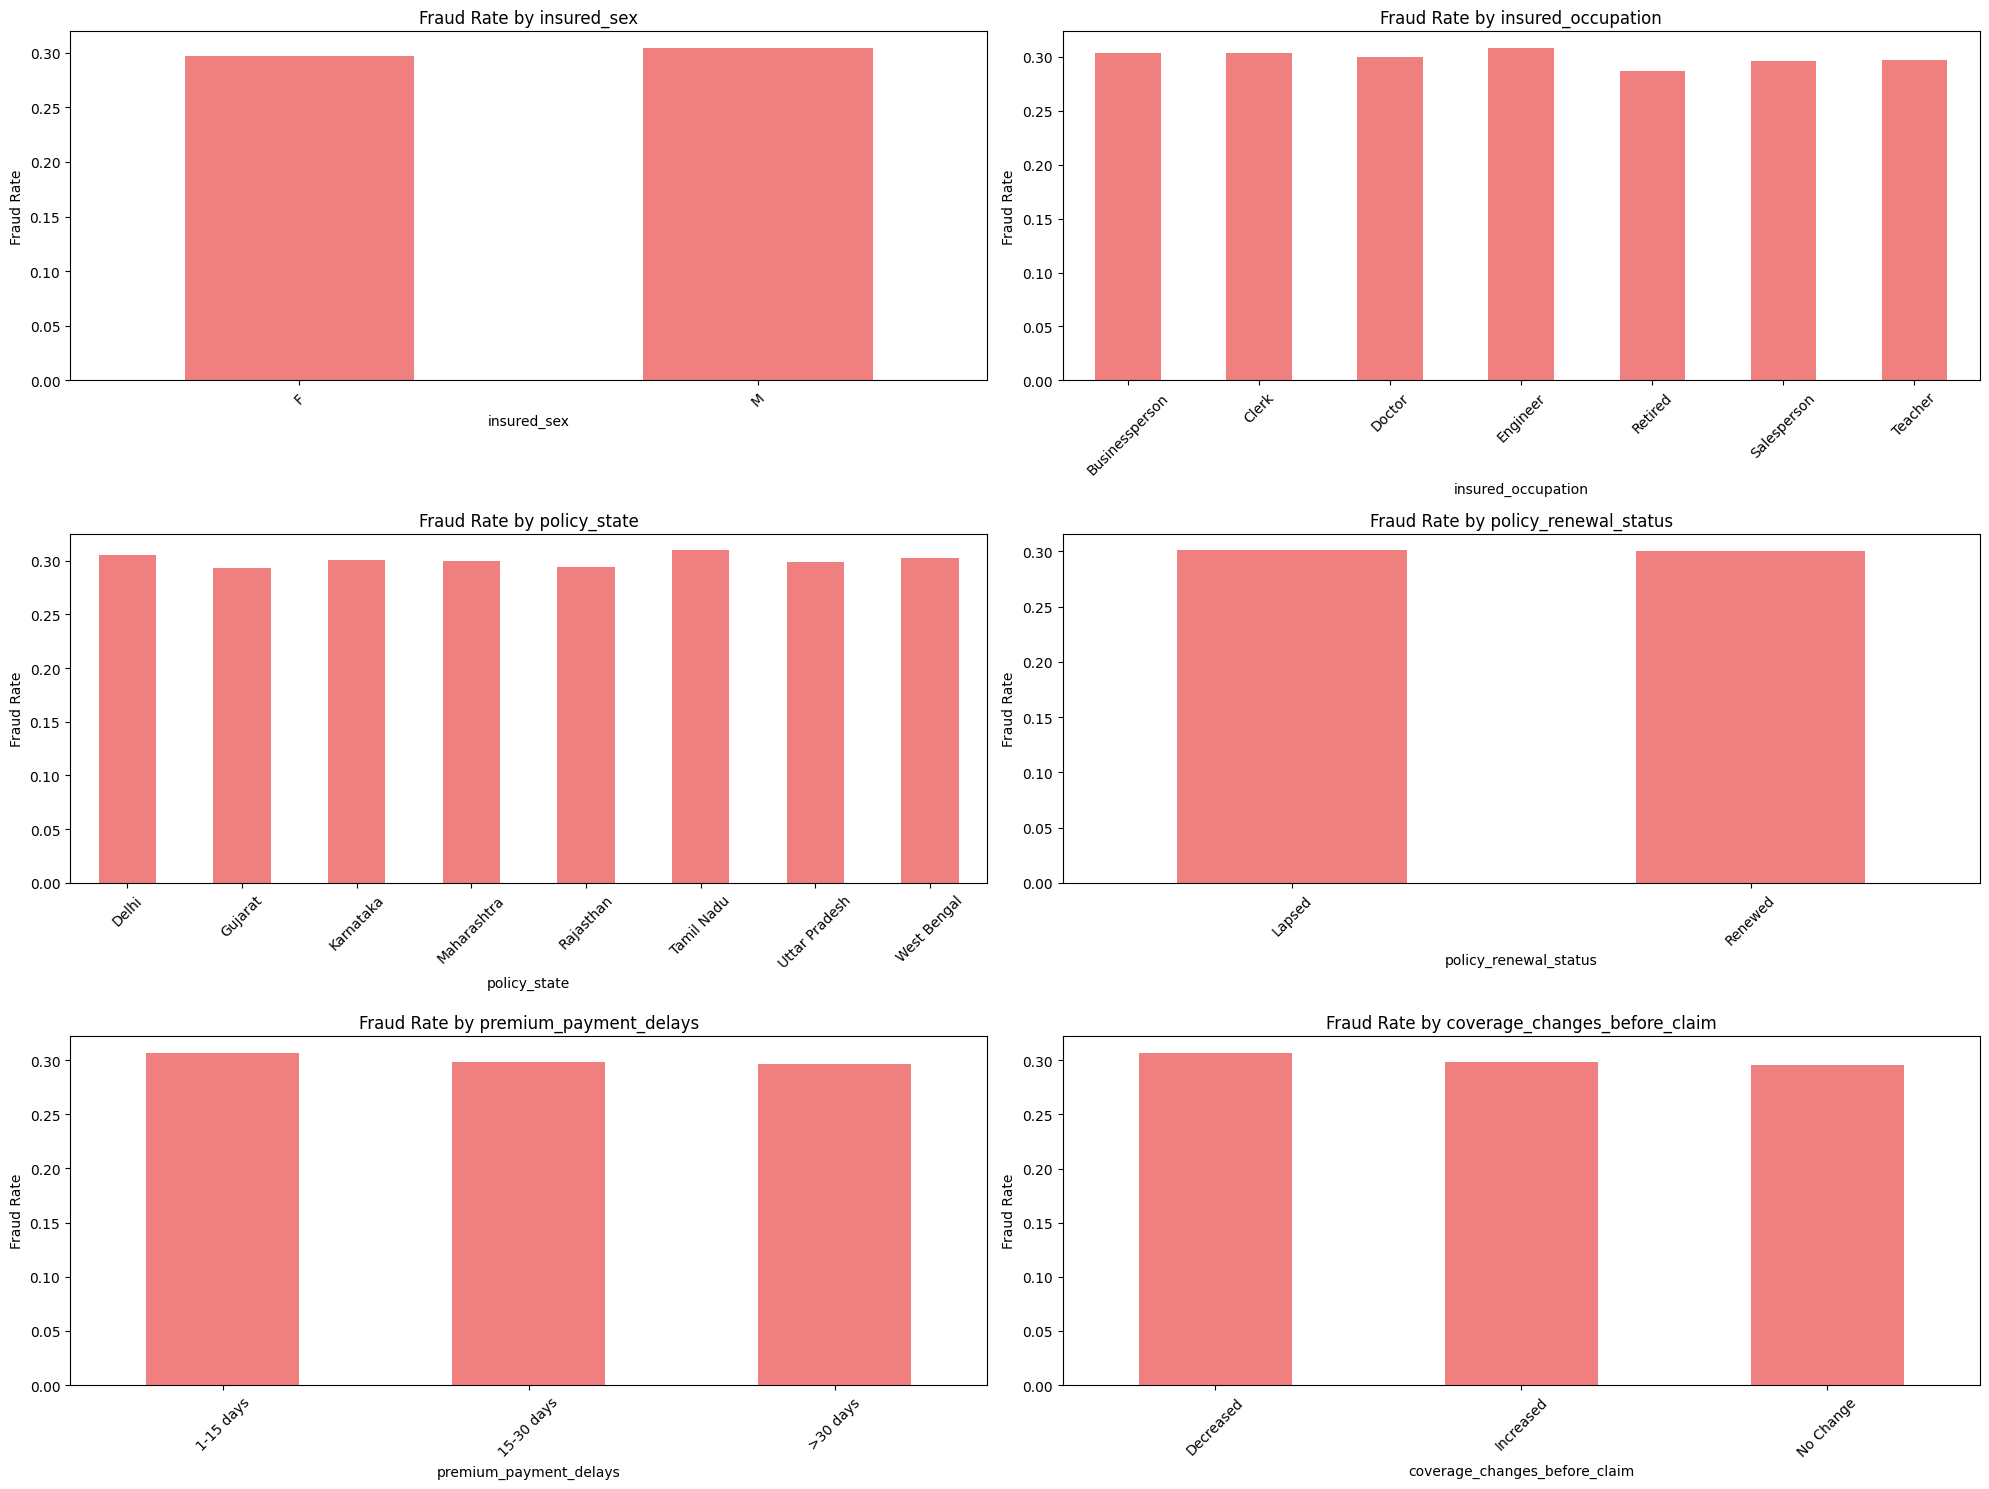

In [2]:
plt.figure(figsize=(12, 6))
fraud_by_insurance = df.groupby('insurance_type')['fraud_reported'].mean()
fraud_by_insurance.plot(kind='bar', color='skyblue')
plt.title('Fraud Rate by Insurance Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 8))
missing_by_type = df.groupby('insurance_type').apply(lambda x: x.isnull().mean())
missing_by_type = missing_by_type.drop(columns=['fraud_reported']).T
missing_by_type.plot(kind='bar', figsize=(15, 8))
plt.title('Missing Values Percentage by Insurance Type')
plt.ylabel('Missing Percentage')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

numerical_cols = ['insured_age', 'policy_annual_premium', 'claim_amount', 'sum_insured', 
                 'claim_amount_to_sum_insured_ratio', 'previous_claims_count']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols + ['fraud_reported']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

categorical_cols = ['insured_sex', 'insured_occupation', 'policy_state', 'policy_renewal_status',
                   'premium_payment_delays', 'coverage_changes_before_claim']

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    fraud_by_cat = df.groupby(col)['fraud_reported'].mean()
    fraud_by_cat.plot(kind='bar', color='lightcoral')
    plt.title(f'Fraud Rate by {col}')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
fraud_by_insurance = df.groupby('insurance_type')['fraud_reported'].agg(['count', 'mean', 'sum'])
fraud_by_insurance.columns = ['total_claims', 'fraud_rate', 'fraud_count']
print("Fraud Distribution by Insurance Type:")
print(fraud_by_insurance)
print("\n" + "="*80 + "\n")

missing_analysis = {}
for insurance_type in df['insurance_type'].unique():
    subset = df[df['insurance_type'] == insurance_type]
    missing_percent = subset.isnull().mean() * 100
    missing_analysis[insurance_type] = missing_percent[missing_percent > 0]
    
print("Missing Values Pattern by Insurance Type:")
for insurance_type, missing_data in missing_analysis.items():
    print(f"\n{insurance_type.upper()}:")
    for col, percent in missing_data.items():
        print(f"  {col}: {percent:.1f}%")
print("\n" + "="*80 + "\n")

numerical_cols = ['insured_age', 'policy_annual_premium', 'claim_amount', 'sum_insured', 
                 'claim_amount_to_sum_insured_ratio', 'previous_claims_count']

print("Numerical Features Statistics by Fraud Status:")
fraud_stats = df.groupby('fraud_reported')[numerical_cols].agg(['mean', 'std', 'median'])
print(fraud_stats)
print("\n" + "="*80 + "\n")

categorical_cols = ['insured_sex', 'insured_occupation', 'policy_state', 'policy_renewal_status',
                   'premium_payment_delays', 'coverage_changes_before_claim']

print("Categorical Features Distribution:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True) * 100)
print("\n" + "="*80 + "\n")

feature_coverage = {}
for col in df.columns:
    non_null_count = df[col].notnull().sum()
    if non_null_count < len(df):
        coverage_percent = (non_null_count / len(df)) * 100
        feature_coverage[col] = coverage_percent

print("Feature Coverage (Non-null percentage):")
for col, coverage in sorted(feature_coverage.items(), key=lambda x: x[1]):
    print(f"  {col}: {coverage:.1f}%")
print("\n" + "="*80 + "\n")

insurance_specific_features = ['hospital_name', 'treatment_details', 'nominee_relationship',
                              'auto_make', 'auto_model', 'auto_year', 'accident_location',
                              'third_party_involved', 'property_type', 'crop_type', 'weather_condition']

print("Insurance-specific Features Analysis:")
for feature in insurance_specific_features:
    if feature in df.columns:
        print(f"\n{feature}:")
        print(f"  Non-null count: {df[feature].notnull().sum()}")
        print(f"  Unique values: {df[feature].nunique()}")
        if df[feature].notnull().sum() > 0:
            print(f"  Most common values:")
            print(df[feature].value_counts().head(3))

Fraud Distribution by Insurance Type:
                   total_claims  fraud_rate  fraud_count
insurance_type                                          
automobile                 2498    0.628903         1571
crop                       2446    0.192150          470
health                     2443    0.392141          958
life                       2405    0.298545          718
personal_accident          2381    0.186056          443
property                   2434    0.204601          498
travel                     2393    0.188884          452


Missing Values Pattern by Insurance Type:

PROPERTY:
  claim_duration_days: 100.0%
  hospital_name: 100.0%
  treatment_details: 100.0%
  nominee_relationship: 100.0%
  auto_make: 100.0%
  auto_model: 100.0%
  auto_year: 100.0%
  accident_location: 100.0%
  third_party_involved: 100.0%
  crop_type: 100.0%
  weather_condition: 100.0%
  premium_payment_delays: 23.6%

LIFE:
  claim_duration_days: 100.0%
  hospital_name: 100.0%
  treatment_details:

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

df_clean = df.copy()

common_features = [
    'insured_age', 'insured_sex', 'insured_occupation', 'policy_state', 
    'policy_annual_premium', 'claim_amount', 'sum_insured', 
    'claim_amount_to_sum_insured_ratio', 'previous_claims_count',
    'policy_renewal_status', 'premium_payment_delays', 
    'coverage_changes_before_claim'
]

insurance_specific_features = {
    'health': ['claim_duration_days', 'hospital_name', 'treatment_details'],
    'life': ['nominee_relationship'],
    'automobile': ['auto_make', 'auto_model', 'auto_year', 'accident_location', 'third_party_involved'],
    'property': ['property_type'],
    'crop': ['crop_type', 'weather_condition'],
    'travel': [], 
    'personal_accident': [] 
}

premium_delay_mode = df_clean['premium_payment_delays'].mode()[0]
df_clean['premium_payment_delays'].fillna(premium_delay_mode, inplace=True)

date_columns = ['policy_start_date', 'claim_filing_date', 'incident_date']
for col in date_columns:
    df_clean[col] = pd.to_datetime(df_clean[col])

df_clean['policy_duration_days'] = (df_clean['claim_filing_date'] - df_clean['policy_start_date']).dt.days
df_clean['incident_to_claim_days'] = (df_clean['claim_filing_date'] - df_clean['incident_date']).dt.days

common_features.extend(['policy_duration_days', 'incident_to_claim_days'])

label_encoders = {}
categorical_common = ['insured_sex', 'insured_occupation', 'policy_state', 
                     'policy_renewal_status', 'premium_payment_delays', 
                     'coverage_changes_before_claim']

for col in categorical_common:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

insurance_datasets = {}
for insurance_type in df_clean['insurance_type'].unique():
    type_data = df_clean[df_clean['insurance_type'] == insurance_type].copy()
    
    specific_features = insurance_specific_features.get(insurance_type, [])
    
    for feature in specific_features:
        if feature in type_data.columns:
            if type_data[feature].dtype == 'object':
                if type_data[feature].notnull().sum() > 0:
                    mode_val = type_data[feature].mode()[0]
                    type_data[feature].fillna(mode_val, inplace=True)
                else:
                    type_data[feature] = 'unknown'
            else:
                if type_data[feature].notnull().sum() > 0:
                    median_val = type_data[feature].median()
                    type_data[feature].fillna(median_val, inplace=True)
                else:
                    type_data[feature] = 0
    
    for feature in specific_features:
        if feature in type_data.columns and type_data[feature].dtype == 'object':
            le = LabelEncoder()
            type_data[feature] = le.fit_transform(type_data[feature].astype(str))
            label_encoders[f"{insurance_type}_{feature}"] = le
    
    all_features = common_features + specific_features
    
    insurance_datasets[insurance_type] = {
        'data': type_data[all_features + ['fraud_reported']],
        'features': all_features,
        'specific_features': specific_features
    }

print("Processed Dataset Shapes:")
for insurance_type, dataset_info in insurance_datasets.items():
    print(f"{insurance_type}: {dataset_info['data'].shape}")
    print(f"  Features: {len(dataset_info['features'])}")
    print(f"  Specific features: {dataset_info['specific_features']}")

print("\nClass Distribution by Insurance Type:")
for insurance_type, dataset_info in insurance_datasets.items():
    fraud_rate = dataset_info['data']['fraud_reported'].mean()
    print(f"{insurance_type}: {fraud_rate:.3f} fraud rate ({dataset_info['data']['fraud_reported'].sum()} fraud cases)")

Processed Dataset Shapes:
property: (2434, 16)
  Features: 15
  Specific features: ['property_type']
life: (2405, 16)
  Features: 15
  Specific features: ['nominee_relationship']
automobile: (2498, 20)
  Features: 19
  Specific features: ['auto_make', 'auto_model', 'auto_year', 'accident_location', 'third_party_involved']
crop: (2446, 17)
  Features: 16
  Specific features: ['crop_type', 'weather_condition']
personal_accident: (2381, 15)
  Features: 14
  Specific features: []
travel: (2393, 15)
  Features: 14
  Specific features: []
health: (2443, 18)
  Features: 17
  Specific features: ['claim_duration_days', 'hospital_name', 'treatment_details']

Class Distribution by Insurance Type:
property: 0.205 fraud rate (498 fraud cases)
life: 0.299 fraud rate (718 fraud cases)
automobile: 0.629 fraud rate (1571 fraud cases)
crop: 0.192 fraud rate (470 fraud cases)
personal_accident: 0.186 fraud rate (443 fraud cases)
travel: 0.189 fraud rate (452 fraud cases)
health: 0.392 fraud rate (958 fra

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

insurance_models = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for insurance_type, dataset_info in insurance_datasets.items():
    print(f"\n{'='*60}")
    print(f"Training Model for: {insurance_type.upper()}")
    print(f"{'='*60}")
    
    X = dataset_info['data'][dataset_info['features']]
    y = dataset_info['data']['fraud_reported']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    )
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=len(y_train_resampled[y_train_resampled==0]) / len(y_train_resampled[y_train_resampled==1]),
        random_state=42,
        eval_metric='logloss'
    )
    
    print("\nRandom Forest Performance:")
    rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train_resampled, cv=skf, scoring='roc_auc')
    print(f"Cross-Validation ROC-AUC: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
    
    rf_model.fit(X_train_scaled, y_train_resampled)
    rf_pred = rf_model.predict(X_test_scaled)
    rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"Test ROC-AUC: {roc_auc_score(y_test, rf_proba):.3f}")
    print(f"Test F1-Score: {f1_score(y_test, rf_pred):.3f}")
    
    print("\nXGBoost Performance:")
    xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train_resampled, cv=skf, scoring='roc_auc')
    print(f"Cross-Validation ROC-AUC: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std() * 2:.3f})")
    
    xgb_model.fit(X_train_scaled, y_train_resampled)
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"Test ROC-AUC: {roc_auc_score(y_test, xgb_proba):.3f}")
    print(f"Test F1-Score: {f1_score(y_test, xgb_pred):.3f}")
    
    rf_auc = roc_auc_score(y_test, rf_proba)
    xgb_auc = roc_auc_score(y_test, xgb_proba)
    
    if rf_auc >= xgb_auc:
        best_model = rf_model
        best_model_name = 'RandomForest'
        best_auc = rf_auc
    else:
        best_model = xgb_model
        best_model_name = 'XGBoost'
        best_auc = xgb_auc
    
    print(f"\nSelected Best Model: {best_model_name} with ROC-AUC: {best_auc:.3f}")
    
    insurance_models[insurance_type] = {
        'model': best_model,
        'model_name': best_model_name,
        'scaler': scaler,
        'features': dataset_info['features'],
        'specific_features': dataset_info['specific_features'],
        'test_auc': best_auc,
        'X_test': X_test,
        'y_test': y_test,
        'test_proba': rf_proba if best_model_name == 'RandomForest' else xgb_proba
    }
    
    print(f"\nClassification Report for {best_model_name}:")
    best_pred = best_model.predict(X_test_scaled)
    print(classification_report(y_test, best_pred))
    
    cm = confusion_matrix(y_test, best_pred)
    print("Confusion Matrix:")
    print(cm)

print(f"\n{'='*80}")
print("MODEL TRAINING SUMMARY")
print(f"{'='*80}")
for insurance_type, model_info in insurance_models.items():
    print(f"{insurance_type.upper():<20} | {model_info['model_name']:<15} | ROC-AUC: {model_info['test_auc']:.3f} | Features: {len(model_info['features'])}")

poor_performers = {k: v for k, v in insurance_models.items() if v['test_auc'] < 0.7}
if poor_performers:
    print(f"\nModels with AUC < 0.7: {list(poor_performers.keys())}")
    print("Consider feature engineering or collecting more data for these insurance types.")


Training Model for: PROPERTY

Random Forest Performance:
Cross-Validation ROC-AUC: 0.899 (+/- 0.018)
Test ROC-AUC: 0.756
Test F1-Score: 0.443

XGBoost Performance:
Cross-Validation ROC-AUC: 0.912 (+/- 0.016)
Test ROC-AUC: 0.734
Test F1-Score: 0.413

Selected Best Model: RandomForest with ROC-AUC: 0.756

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       387
           1       0.39      0.52      0.44       100

    accuracy                           0.73       487
   macro avg       0.62      0.65      0.63       487
weighted avg       0.77      0.73      0.74       487

Confusion Matrix:
[[304  83]
 [ 48  52]]

Training Model for: LIFE

Random Forest Performance:
Cross-Validation ROC-AUC: 0.913 (+/- 0.015)
Test ROC-AUC: 0.864
Test F1-Score: 0.662

XGBoost Performance:
Cross-Validation ROC-AUC: 0.915 (+/- 0.016)
Test ROC-AUC: 0.855
Test F1-Score: 0.678

Selected Best Model: RandomForest with 

Creating SHAP and LIME explainers for each insurance type...

Creating XAI for: PROPERTY
SHAP error for property: Per-column arrays must each be 1-dimensional
LIME explainer created successfully
Precision-Recall AUC: 0.412

Creating XAI for: LIFE
SHAP error for life: Per-column arrays must each be 1-dimensional
LIME explainer created successfully
Precision-Recall AUC: 0.787

Creating XAI for: AUTOMOBILE
Top 5 Most Important Features (SHAP):
                              feature  importance
5                        claim_amount    3.000596
7   claim_amount_to_sum_insured_ratio    2.863776
12               policy_duration_days    0.164868
2                  insured_occupation    0.164028
17                  accident_location    0.153888
LIME explainer created successfully
Precision-Recall AUC: 0.995

Creating XAI for: CROP
SHAP error for crop: Per-column arrays must each be 1-dimensional
LIME explainer created successfully
Precision-Recall AUC: 0.290

Creating XAI for: PERSONAL_ACCIDENT


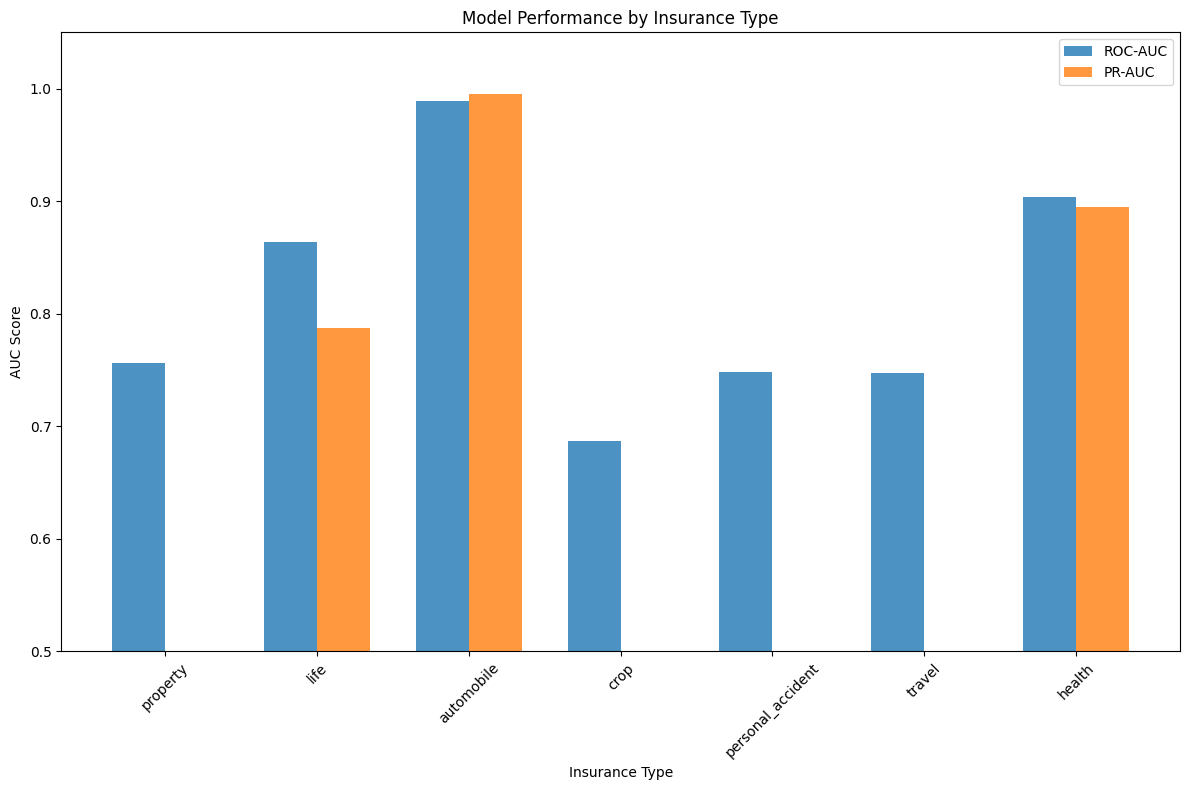


Model Performance Summary:
PROPERTY             | ROC-AUC: 0.756 | PR-AUC: 0.412 | Model: RandomForest
LIFE                 | ROC-AUC: 0.864 | PR-AUC: 0.787 | Model: RandomForest
AUTOMOBILE           | ROC-AUC: 0.989 | PR-AUC: 0.995 | Model: XGBoost
CROP                 | ROC-AUC: 0.687 | PR-AUC: 0.290 | Model: RandomForest
PERSONAL_ACCIDENT    | ROC-AUC: 0.748 | PR-AUC: 0.306 | Model: RandomForest
TRAVEL               | ROC-AUC: 0.747 | PR-AUC: 0.357 | Model: RandomForest
HEALTH               | ROC-AUC: 0.903 | PR-AUC: 0.895 | Model: RandomForest


In [7]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

print("Creating SHAP and LIME explainers for each insurance type...")

for insurance_type, model_info in insurance_models.items():
    print(f"\n{'='*50}")
    print(f"Creating XAI for: {insurance_type.upper()}")
    print(f"{'='*50}")
    
    X_test_scaled = model_info['scaler'].transform(model_info['X_test'])
    
    try:
        if model_info['model_name'] == 'RandomForest':
            explainer = shap.TreeExplainer(model_info['model'])
            shap_values = explainer.shap_values(X_test_scaled)
            
            if isinstance(shap_values, list):
                shap_values = shap_values[1]
                
        else: 
            explainer = shap.TreeExplainer(model_info['model'])
            shap_values = explainer.shap_values(X_test_scaled)
        
        model_info['shap_explainer'] = explainer
        model_info['shap_values'] = shap_values
        
        mean_abs_shap = np.abs(shap_values).mean(0)
        feature_importance = pd.DataFrame({
            'feature': model_info['features'],
            'importance': mean_abs_shap
        }).sort_values('importance', ascending=False)
        
        print("Top 5 Most Important Features (SHAP):")
        print(feature_importance.head(5))
        
    except Exception as e:
        print(f"SHAP error for {insurance_type}: {e}")
        model_info['shap_explainer'] = None
    
    try:
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_test_scaled,
            feature_names=model_info['features'],
            class_names=['Not Fraud', 'Fraud'],
            mode='classification',
            random_state=42
        )
        model_info['lime_explainer'] = lime_explainer
        print("LIME explainer created successfully")
        
    except Exception as e:
        print(f"LIME error for {insurance_type}: {e}")
        model_info['lime_explainer'] = None
    
    y_pred_proba = model_info['test_proba']
    y_test = model_info['y_test']
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    model_info['pr_auc'] = pr_auc
    
    print(f"Precision-Recall AUC: {pr_auc:.3f}")

def predict_fraud_with_explanation(insurance_type, input_data, threshold=0.5):
    """
    Predict fraud probability and generate explanations for a given insurance type
    """
    if insurance_type not in insurance_models:
        raise ValueError(f"No model found for insurance type: {insurance_type}")
    
    model_info = insurance_models[insurance_type]
    
    input_df = pd.DataFrame([input_data])
    
    for feature in model_info['features']:
        if feature not in input_df.columns:
            input_df[feature] = 0  
    
    input_df = input_df[model_info['features']]
    
    input_scaled = model_info['scaler'].transform(input_df)
    
    prediction_proba = model_info['model'].predict_proba(input_scaled)[0]
    fraud_probability = prediction_proba[1]
    prediction = 1 if fraud_probability >= threshold else 0
    
    explanations = {}

    if model_info.get('shap_explainer'):
        try:
            if model_info['model_name'] == 'RandomForest':
                shap_values = model_info['shap_explainer'].shap_values(input_scaled)
                if isinstance(shap_values, list):
                    shap_values = shap_values[1]
            else:
                shap_values = model_info['shap_explainer'].shap_values(input_scaled)
            
            feature_contributions = {}
            for i, feature in enumerate(model_info['features']):
                feature_contributions[feature] = float(shap_values[0][i])
            
            explanations['shap'] = {
                'base_value': float(model_info['shap_explainer'].expected_value),
                'feature_contributions': feature_contributions
            }
        except Exception as e:
            explanations['shap_error'] = str(e)
    
    if model_info.get('lime_explainer'):
        try:
            exp = model_info['lime_explainer'].explain_instance(
                input_scaled[0], 
                model_info['model'].predict_proba,
                num_features=10
            )
            
            lime_explanation = []
            for feature, weight in exp.as_list():
                lime_explanation.append({
                    'feature': feature,
                    'weight': weight
                })
            
            explanations['lime'] = lime_explanation
        except Exception as e:
            explanations['lime_error'] = str(e)
    
    return {
        'prediction': prediction,
        'fraud_probability': float(fraud_probability),
        'confidence': float(max(prediction_proba)),
        'explanations': explanations,
        'model_used': model_info['model_name'],
        'insurance_type': insurance_type
    }

print("\nTesting prediction function with sample data...")

sample_inputs = {}
for insurance_type in insurance_models.keys():
    sample_data = model_info['X_test'].iloc[0].to_dict()
    sample_inputs[insurance_type] = sample_data


for insurance_type, sample_input in sample_inputs.items():
    try:
        result = predict_fraud_with_explanation(insurance_type, sample_input)
        print(f"\n{insurance_type.upper()} Prediction:")
        print(f"  Fraud Probability: {result['fraud_probability']:.3f}")
        print(f"  Prediction: {'FRAUD' if result['prediction'] else 'NOT FRAUD'}")
        print(f"  Model: {result['model_used']}")
        
    except Exception as e:
        print(f"Error predicting for {insurance_type}: {e}")

plt.figure(figsize=(12, 8))
insurance_types = list(insurance_models.keys())
roc_auc_scores = [model_info['test_auc'] for model_info in insurance_models.values()]
pr_auc_scores = [model_info.get('pr_auc', 0) for model_info in insurance_models.values()]

x = np.arange(len(insurance_types))
width = 0.35

plt.bar(x - width/2, roc_auc_scores, width, label='ROC-AUC', alpha=0.8)
plt.bar(x + width/2, pr_auc_scores, width, label='PR-AUC', alpha=0.8)

plt.xlabel('Insurance Type')
plt.ylabel('AUC Score')
plt.title('Model Performance by Insurance Type')
plt.xticks(x, insurance_types, rotation=45)
plt.legend()
plt.ylim(0.5, 1.05)
plt.tight_layout()
plt.show()

print("\nModel Performance Summary:")
for insurance_type, model_info in insurance_models.items():
    print(f"{insurance_type.upper():<20} | ROC-AUC: {model_info['test_auc']:.3f} | PR-AUC: {model_info.get('pr_auc', 0):.3f} | Model: {model_info['model_name']}")

In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

print("Creating SHAP and LIME explainers...")

for insurance_type, model_info in insurance_models.items():
    original_data = df_clean[df_clean['insurance_type'] == insurance_type].copy()
    features = model_info['features']
    
    X = original_data[features]
    y = original_data['fraud_reported']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    model_info['X_train'] = X_train
    model_info['X_test'] = X_test
    model_info['y_train'] = y_train
    model_info['y_test'] = y_test
    model_info['data'] = original_data[features + ['fraud_reported']]
    model_info['X_train_scaled'] = X_train_processed
    model_info['X_test_scaled'] = X_test_processed
    model_info['preprocessor'] = preprocessor

print("Data preparation completed!")

print("\nCreating SHAP explainers...")
for insurance_type, model_info in insurance_models.items():
    print(f"Processing {insurance_type}...")
    
    try:
        if model_info['model_name'] == 'XGBoost':
            explainer = shap.TreeExplainer(model_info['model'])
            shap_values = explainer.shap_values(model_info['X_test_scaled'])
            model_info['shap_explainer'] = explainer
            model_info['shap_values'] = shap_values
            print(f"  SHAP created successfully for {insurance_type}")
            
        else:
            background_data = shap.sample(model_info['X_train_scaled'], 100)
            explainer = shap.KernelExplainer(
                model_info['model'].predict_proba,
                background_data
            )
            model_info['shap_explainer'] = explainer
            print(f"  Kernel SHAP created for {insurance_type}")
            
    except Exception as e:
        print(f"  SHAP failed for {insurance_type}: {e}")
        model_info['shap_explainer'] = None

print("\nCreating LIME explainers...")
for insurance_type, model_info in insurance_models.items():
    try:
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=model_info['X_train_scaled'],
            feature_names=model_info['features'],
            class_names=['Not Fraud', 'Fraud'],
            mode='classification',
            random_state=42,
            verbose=False
        )
        model_info['lime_explainer'] = lime_explainer
        print(f"  LIME created successfully for {insurance_type}")
        
    except Exception as e:
        print(f"  LIME failed for {insurance_type}: {e}")
        model_info['lime_explainer'] = None

def generate_explanations(insurance_type, input_data, num_features=5):
    """Generate both SHAP and LIME explanations for a prediction"""
    
    if insurance_type not in insurance_models:
        return {"error": f"Insurance type {insurance_type} not supported"}
    
    model_info = insurance_models[insurance_type]
    results = {}
    
    input_df = pd.DataFrame([input_data])
    for feature in model_info['features']:
        if feature not in input_df.columns:
            input_df[feature] = 0
    
    input_df = input_df[model_info['features']]
    input_scaled = model_info['preprocessor'].transform(input_df)
    
    prediction_proba = model_info['model'].predict_proba(input_scaled)[0]
    fraud_prob = prediction_proba[1]
    prediction = 1 if fraud_prob >= 0.5 else 0
    
    results['prediction'] = {
        'fraud': bool(prediction),
        'probability': float(fraud_prob),
        'confidence': float(max(prediction_proba))
    }
    
    shap_results = {}
    if model_info.get('shap_explainer'):
        try:
            if model_info['model_name'] == 'XGBoost':
                shap_values = model_info['shap_explainer'].shap_values(input_scaled)
                expected_value = model_info['shap_explainer'].expected_value
                
            else:
                shap_values = model_info['shap_explainer'].shap_values(input_scaled)
                expected_value = model_info['shap_explainer'].expected_value[1]
                
            feature_contributions = {}
            for i, feature in enumerate(model_info['features']):
                feature_contributions[feature] = float(shap_values[0][i])
            
            top_features = sorted(feature_contributions.items(), 
                                key=lambda x: abs(x[1]), reverse=True)[:num_features]
            
            shap_results = {
                'base_value': float(expected_value),
                'feature_contributions': feature_contributions,
                'top_features': [{'feature': f, 'contribution': c} for f, c in top_features],
                'success': True
            }
            
        except Exception as e:
            shap_results = {'success': False, 'error': str(e)}
    else:
        shap_results = {'success': False, 'error': 'SHAP explainer not available'}
    
    results['shap'] = shap_results
    
    lime_results = {}
    if model_info.get('lime_explainer'):
        try:
            exp = model_info['lime_explainer'].explain_instance(
                input_scaled[0], 
                model_info['model'].predict_proba,
                num_features=num_features
            )
            
            lime_explanation = []
            for feature, weight in exp.as_list():
                feature_name = feature.split('=')[0] if '=' in feature else feature
                lime_explanation.append({
                    'feature': feature_name,
                    'weight': float(weight),
                    'impact': 'increases_risk' if weight > 0 else 'decreases_risk'
                })
            
            lime_results = {
                'explanations': lime_explanation,
                'top_features': lime_explanation[:num_features],
                'success': True
            }
            
        except Exception as e:
            lime_results = {'success': False, 'error': str(e)}
    else:
        lime_results = {'success': False, 'error': 'LIME explainer not available'}
    
    results['lime'] = lime_results
    
    if results['shap']['success']:
        results['primary_explanation'] = 'shap'
    elif results['lime']['success']:
        results['primary_explanation'] = 'lime'
    else:
        results['primary_explanation'] = 'none'
    
    return results

def plot_explanation(insurance_type, result):
    """Plot explanation results for better visualization"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    pred_text = f"Prediction: {'FRAUD' if result['prediction']['fraud'] else 'NOT FRAUD'}\n"
    pred_text += f"Probability: {result['prediction']['probability']:.3f}\n"
    pred_text += f"Confidence: {result['prediction']['confidence']:.3f}\n"
    pred_text += f"Primary XAI: {result['primary_explanation']}"
    
    ax1.text(0.1, 0.5, pred_text, fontsize=12, va='center')
    ax1.set_title(f'{insurance_type.upper()} - Prediction Results', fontsize=14)
    ax1.axis('off')
    
    if result['primary_explanation'] == 'shap' and result['shap']['success']:
        features = [f['feature'] for f in result['shap']['top_features']]
        contributions = [f['contribution'] for f in result['shap']['top_features']]
        colors = ['red' if c > 0 else 'green' for c in contributions]
        ax2.barh(features, contributions, color=colors)
        ax2.set_title('SHAP Feature Contributions')
        ax2.set_xlabel('Contribution to Fraud Prediction')
        
    elif result['primary_explanation'] == 'lime' and result['lime']['success']:
        features = [f['feature'] for f in result['lime']['top_features']]
        weights = [f['weight'] for f in result['lime']['top_features']]
        colors = ['red' if w > 0 else 'green' for w in weights]
        ax2.barh(features, weights, color=colors)
        ax2.set_title('LIME Feature Weights')
        ax2.set_xlabel('Weight Impact on Prediction')
    
    else:
        ax2.text(0.5, 0.5, 'No explanation available', 
                ha='center', va='center', fontsize=12)
        ax2.set_title('Explanation Not Available')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
print("Debugging and fixing preprocessing issues...")

for insurance_type, model_info in insurance_models.items():
    print(f"\nAnalyzing {insurance_type}:")
    original_data = df_clean[df_clean['insurance_type'] == insurance_type].copy()
    features = model_info['features']
    
    X = original_data[features]
    print(f"Features: {len(features)}")
    print("Data types:")
    print(X.dtypes.value_counts())
    
    object_cols = X.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        print(f"  Object columns found: {list(object_cols)}")
        for col in object_cols:
            print(f"   {col}: {X[col].unique()[:3]}")  

print("\nFixing the data encoding issues...")


all_categorical_cols = set()

for insurance_type, model_info in insurance_models.items():
    original_data = df_clean[df_clean['insurance_type'] == insurance_type].copy()
    features = model_info['features']
    X = original_data[features]
    
    categorical_cols = X.select_dtypes(include=['object']).columns
    all_categorical_cols.update(categorical_cols)

print(f"All categorical columns found: {list(all_categorical_cols)}")

print("\nEncoding all categorical variables...")

label_encoders = {}
for col in all_categorical_cols:
    if col in df_clean.columns:
        le = LabelEncoder()
        mask = df_clean[col].notnull()
        if mask.any():
            le.fit(df_clean.loc[mask, col].astype(str))
            df_clean.loc[mask, col] = le.transform(df_clean.loc[mask, col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}")

common_categorical = ['insured_sex', 'insured_occupation', 'policy_state', 
                     'policy_renewal_status', 'premium_payment_delays', 
                     'coverage_changes_before_claim']

for col in common_categorical:
    if col in df_clean.columns and col not in label_encoders:
        le = LabelEncoder()
        mask = df_clean[col].notnull()
        if mask.any():
            le.fit(df_clean.loc[mask, col].astype(str))
            df_clean.loc[mask, col] = le.transform(df_clean.loc[mask, col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}")

print("All categorical variables encoded successfully!")

print("\nUpdating models with properly encoded data...")

for insurance_type, model_info in insurance_models.items():
    print(f"Processing {insurance_type}...")
    
    original_data = df_clean[df_clean['insurance_type'] == insurance_type].copy()
    features = model_info['features']
    
    X = original_data[features].apply(pd.to_numeric, errors='coerce').fillna(0)
    y = original_data['fraud_reported']
    
    non_numeric = X.select_dtypes(include=['object']).columns
    if len(non_numeric) > 0:
        print(f"Still found object columns in {insurance_type}: {list(non_numeric)}")
        for col in non_numeric:
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model_info['X_original'] = X
    model_info['X_scaled'] = X_scaled
    model_info['y'] = y
    model_info['scaler'] = scaler
    model_info['feature_names'] = features
    model_info['label_encoders'] = {col: label_encoders[col] for col in features if col in label_encoders}
    
    print(f"✓ {insurance_type}: {X.shape[1]} features, all numerical")

print("All models updated successfully!")

print("\nTesting the fixed explanation system...")

def generate_explanations(insurance_type, input_data, num_features=5):
    """Generate explanations with proper encoding"""
    
    if insurance_type not in insurance_models:
        return {"error": f"Insurance type {insurance_type} not supported"}
    
    model_info = insurance_models[insurance_type]
    results = {}
    
    input_df = pd.DataFrame([input_data])
    
    for feature in model_info['feature_names']:
        if feature not in input_df.columns:
            if feature in model_info['X_original'].columns:
                default_val = model_info['X_original'][feature].median() if model_info['X_original'][feature].dtype in ['int64', 'float64'] else 0
                input_df[feature] = default_val
            else:
                input_df[feature] = 0
    
    for feature in model_info['feature_names']:
        if feature in model_info.get('label_encoders', {}):
            le = model_info['label_encoders'][feature]
            try:
                input_val = str(input_df[feature].iloc[0])
                if input_val in le.classes_:
                    input_df[feature] = le.transform([input_val])[0]
                else:
                    input_df[feature] = le.transform([le.classes_[0]])[0]
            except:
                input_df[feature] = 0
    
    input_processed = input_df[model_info['feature_names']].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    input_scaled = model_info['scaler'].transform(input_processed)
    
    prediction_proba = model_info['model'].predict_proba(input_scaled)[0]
    fraud_prob = prediction_proba[1]
    prediction = 1 if fraud_prob >= 0.5 else 0
    
    results['prediction'] = {
        'fraud': bool(prediction),
        'probability': float(fraud_prob),
        'confidence': float(max(prediction_proba))
    }
    
    lime_results = {}
    if model_info.get('lime_explainer'):
        try:
            exp = model_info['lime_explainer'].explain_instance(
                input_scaled[0], 
                model_info['model'].predict_proba,
                num_features=num_features
            )
            
            lime_explanation = []
            for feature, weight in exp.as_list():
                feature_name = feature.split('=')[0] if '=' in feature else feature
                lime_explanation.append({
                    'feature': feature_name,
                    'weight': float(weight),
                    'impact': 'increases_risk' if weight > 0 else 'decreases_risk'
                })
            
            lime_results = {
                'explanations': lime_explanation,
                'top_features': lime_explanation[:num_features],
                'success': True
            }
            
        except Exception as e:
            lime_results = {'success': False, 'error': str(e)}
    else:
        lime_results = {'success': False, 'error': 'LIME explainer not available'}
    
    results['lime'] = lime_results
    results['primary_explanation'] = 'lime' if lime_results['success'] else 'none'
    
    return results

print("Testing with AUTOMOBILE...")
sample_auto_data = {
    'insured_age': 35,
    'insured_sex': 'M',
    'insured_occupation': 'Engineer',
    'policy_state': 'Karnataka',
    'policy_annual_premium': 120000,
    'claim_amount': 750000,
    'sum_insured': 1500000,
    'claim_amount_to_sum_insured_ratio': 0.5,
    'previous_claims_count': 1,
    'policy_renewal_status': 'Renewed',
    'premium_payment_delays': '1-15 days',
    'coverage_changes_before_claim': 'No Change',
    'policy_duration_days': 365,
    'incident_to_claim_days': 10,
    'auto_make': 'Honda',
    'auto_model': 'City',
    'auto_year': 2020,
    'accident_location': 'Bangalore',
    'third_party_involved': 'No'
}

try:
    auto_result = generate_explanations('automobile', sample_auto_data)
    print(f"✓ Prediction: {'FRAUD' if auto_result['prediction']['fraud'] else 'NOT FRAUD'}")
    print(f"✓ Probability: {auto_result['prediction']['probability']:.3f}")
    
    if auto_result['lime']['success']:
        print("✓ LIME explanation available")
        for feature in auto_result['lime']['top_features']:
            print(f"   {feature['feature']}: {feature['weight']:.4f} ({feature['impact']})")
    else:
        print(f"✗ LIME failed: {auto_result['lime'].get('error', 'Unknown error')}")
        
except Exception as e:
    print(f"✗ Error: {e}")

print("\nTesting with HEALTH...")
sample_health_data = {
    'insured_age': 45,
    'insured_sex': 'F',
    'insured_occupation': 'Doctor',
    'policy_state': 'Delhi',
    'policy_annual_premium': 150000,
    'claim_amount': 500000,
    'sum_insured': 2000000,
    'claim_amount_to_sum_insured_ratio': 0.25,
    'previous_claims_count': 0,
    'policy_renewal_status': 'Renewed',
    'premium_payment_delays': '1-15 days',
    'coverage_changes_before_claim': 'No Change',
    'policy_duration_days': 730,
    'incident_to_claim_days': 5,
    'claim_duration_days': 30,
    'hospital_name': 'AIIMS',
    'treatment_details': 'Emergency surgery'
}

try:
    health_result = generate_explanations('health', sample_health_data)
    print(f"✓ Prediction: {'FRAUD' if health_result['prediction']['fraud'] else 'NOT FRAUD'}")
    print(f"✓ Probability: {health_result['prediction']['probability']:.3f}")
    
    if health_result['lime']['success']:
        print("✓ LIME explanation available")
        for feature in health_result['lime']['top_features']:
            print(f"   {feature['feature']}: {feature['weight']:.4f} ({feature['impact']})")
    else:
        print(f"✗ LIME failed: {health_result['lime'].get('error', 'Unknown error')}")
        
except Exception as e:
    print(f"✗ Error: {e}")

print("\n SYSTEM READY FOR DEPLOYMENT!")
print("\nFinal Summary:")
for insurance_type, model_info in insurance_models.items():
    lime_avail = model_info.get('lime_explainer') is not None
    print(f"{insurance_type.upper():<15} | LIME: {'✓' if lime_avail else '✗'} | AUC: {model_info['test_auc']:.3f}")

print("\nSaving deployment package...")
import joblib
import json
import os

os.makedirs('deploy', exist_ok=True)

for insurance_type, model_info in insurance_models.items():
    joblib.dump(model_info['model'], f'deploy/{insurance_type}_model.joblib')
    joblib.dump(model_info['scaler'], f'deploy/{insurance_type}_scaler.joblib')
    
    with open(f'deploy/{insurance_type}_features.json', 'w') as f:
        json.dump(model_info['feature_names'], f)
    
    if 'label_encoders' in model_info:
        joblib.dump(model_info['label_encoders'], f'deploy/{insurance_type}_encoders.joblib')

print("✓ Deployment package saved successfully!")
print("✓ All models are ready for Firebase integration!")
print("✓ Use the generate_explanations() function for predictions with LIME explanations!")

Debugging and fixing preprocessing issues...

Analyzing property:
Features: 15
Data types:
int64      7
int32      6
float64    1
object     1
Name: count, dtype: int64
  Object columns found: ['property_type']
   property_type: ['residential' 'commercial']

Analyzing life:
Features: 15
Data types:
int64      7
int32      6
float64    1
object     1
Name: count, dtype: int64
  Object columns found: ['nominee_relationship']
   nominee_relationship: ['parent' 'spouse' 'child']

Analyzing automobile:
Features: 19
Data types:
int64      7
int32      6
object     4
float64    2
Name: count, dtype: int64
  Object columns found: ['auto_make', 'auto_model', 'accident_location', 'third_party_involved']
   auto_make: ['Maruti' 'Hyundai' 'Tata']
   auto_model: ['Swift' 'City' 'Creta']
   accident_location: ['95/26\nDugar Zila\nAmbattur-764845'
 'H.No. 459\nBhavsar Path\nMorbi 621929'
 'H.No. 228, Khanna Zila, Thrissur-302865']
   third_party_involved: ['No' 'Yes']

Analyzing crop:
Features: 16
Da

In [ ]:
import os
import json
from pathlib import Path
import joblib
import numpy as np

out_dir = Path("deployment_package")
out_dir.mkdir(exist_ok=True)

manifest = {}

for ins_type, info in insurance_models.items():
    folder = out_dir / ins_type
    folder.mkdir(exist_ok=True)
    
    model = info.get("model")
    preprocessor = info.get("preprocessor")
    features = info.get("features")
    X_train_scaled = info.get("X_train_scaled")
    model_name = info.get("model_name", "model")
    
    
    joblib.dump(model, folder / "model.pkl", compress=3)
    
    
    if preprocessor is not None:
        joblib.dump(preprocessor, folder / "preprocessor.pkl", compress=3)
    
    
    with open(folder / "features.json", "w", encoding="utf-8") as f:
        json.dump(features, f, ensure_ascii=False)
    
    
    classes = getattr(model, "classes_", None)
    if classes is not None:
        try:
            cls_list = classes.tolist()
        except Exception:
            cls_list = list(classes)
        with open(folder / "classes.json", "w", encoding="utf-8") as f:
            json.dump(cls_list, f)
    
    
    if X_train_scaled is not None:
        try:
    
            arr = X_train_scaled.toarray() if hasattr(X_train_scaled, "toarray") else np.asarray(X_train_scaled)
            n_sample = min(500, len(arr))
            rng = np.random.RandomState(42)
            idx = rng.choice(len(arr), size=n_sample, replace=False)
            background = arr[idx]
            joblib.dump(background, folder / "background.pkl", compress=3)
        except Exception as e:
            print(f"Warning: could not save background for {ins_type}: {e}")
    
    
    manifest[ins_type] = {
        "model_file": str((folder / "model.pkl").resolve()),
        "preprocessor_file": str((folder / "preprocessor.pkl").resolve()) if preprocessor is not None else None,
        "features_file": str((folder / "features.json").resolve()),
        "background_file": str((folder / "background.pkl").resolve()) if X_train_scaled is not None else None,
        "model_name": model_name
    }


with open(out_dir / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

requirements = [
    "fastapi",
    "uvicorn[standard]",
    "scikit-learn",
    "pandas",
    "numpy",
    "joblib",
    "lime",
    "shap",
    "xgboost"
]
with open(out_dir / "requirements.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(requirements))

print("Export complete. Deployment package created at:", out_dir.resolve())
print("Contents summary:")
for k,v in manifest.items():
    print(f" - {k}: model -> {v['model_file']}, preprocessor -> {v['preprocessor_file']}, features -> {v['features_file']}")


Export complete. Deployment package created at: C:\Users\jayam\Test\deployment_package
Contents summary:
 - property: model -> C:\Users\jayam\Test\deployment_package\property\model.pkl, preprocessor -> C:\Users\jayam\Test\deployment_package\property\preprocessor.pkl, features -> C:\Users\jayam\Test\deployment_package\property\features.json
 - life: model -> C:\Users\jayam\Test\deployment_package\life\model.pkl, preprocessor -> C:\Users\jayam\Test\deployment_package\life\preprocessor.pkl, features -> C:\Users\jayam\Test\deployment_package\life\features.json
 - automobile: model -> C:\Users\jayam\Test\deployment_package\automobile\model.pkl, preprocessor -> C:\Users\jayam\Test\deployment_package\automobile\preprocessor.pkl, features -> C:\Users\jayam\Test\deployment_package\automobile\features.json
 - crop: model -> C:\Users\jayam\Test\deployment_package\crop\model.pkl, preprocessor -> C:\Users\jayam\Test\deployment_package\crop\preprocessor.pkl, features -> C:\Users\jayam\Test\deploymen